In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  19099      0 --:--:-- --:--:-- --:--:-- 19099


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
INFO:conda_installer:add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.15
INFO:conda_installer:python version: 3.7.15
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
INFO:conda_installer:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
INFO:conda_installer:done
installing miniconda to /root/miniconda
INFO:conda_installer:installing miniconda to /root/miniconda
done
INFO:conda_installer:done
installing openmm, pdbfixer
INFO:conda_installer:installing openmm, pdbfixer
added conda-forge to channels
INFO:conda_installer:added conda-forge to channels
done
INFO:conda_installer:done
conda packages installation finished!
INFO:conda_installer:conda packages installation finished!


# conda environments:
#
base                     /root/miniconda



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 6.6 MB/s 
     |████████████████████████████████| 29.5 MB 75.7 MB/s 


'2.6.2.dev'

In [ ]:
import os
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

current_dir = os.path.dirname(os.path.realpath('__file__'))
dc.utils.download_url(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/atomic_contributions_tutorial_data/logBB.sdf',
    current_dir,
    'logBB.sdf'
)
DATASET_FILE =os.path.join(current_dir, 'logBB.sdf')
# Create RDKit mol objects, since we will need them later.
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]
loader = dc.data.SDFLoader(tasks=["logBB_class"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)


In [ ]:
np.random.seed(2020)
tf.random.set_seed(2020)

In [ ]:
m = dc.models.GraphConvModel(1, mode="classification", batch_normalize=False, batch_size=100)
m.fit(dataset, nb_epoch=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(331,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(331, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(1646,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16

0.5348201115926107

In [ ]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
dc.utils.download_url(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/examples/tutorials/assets/atomic_contributions_tutorial_data/logBB_test_.sdf',
    current_dir,
    'logBB_test_.sdf'
)
TEST_DATASET_FILE = os.path.join(current_dir, 'logBB_test_.sdf')
loader = dc.data.SDFLoader(tasks=["p_np"], sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)
pred =  m.predict(test_dataset)
pred = np.argmax(np.squeeze(pred),axis=1)
ba = metrics.balanced_accuracy_score(y_true=test_dataset.y, y_pred=pred)
print(ba)

0.7444444444444445


In [ ]:
loader = dc.data.SDFLoader(tasks=[],# dont need task (moreover, passing the task can lead to inconsitencies in data shapes)
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/usr/local/lib/python3.7/dist-packages/deepchem/feat/base_classes.py:323: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
/usr/local/lib/python3.7/dist-packages/deepchem/data/data_loader.py:893: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features), valid_inds


In [ ]:
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(5111,)


In [ ]:
# whole  molecules
pred = np.squeeze(m.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(m.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

In [ ]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]
df

,Fragment,Molecule,Contrib
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.756537,0.811549,0.055013
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.752759,0.811549,0.058791
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.747012,0.811549,0.064537
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.815878,0.811549,-0.004328
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.741805,0.811549,0.069744
...,...,...,...
c1cncc(C2CCCN2)c1,0.780473,0.813032,0.032559
c1cncc(C2CCCN2)c1,0.722649,0.813032,0.090383
c1cncc(C2CCCN2)c1,0.721607,0.813032,0.091425
c1cncc(C2CCCN2)c1,0.683299,0.813032,0.129733


In [ ]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps  

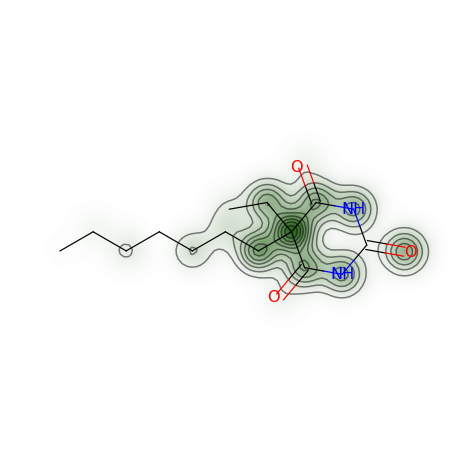

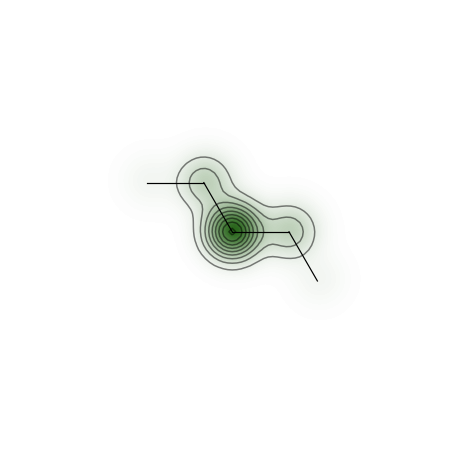

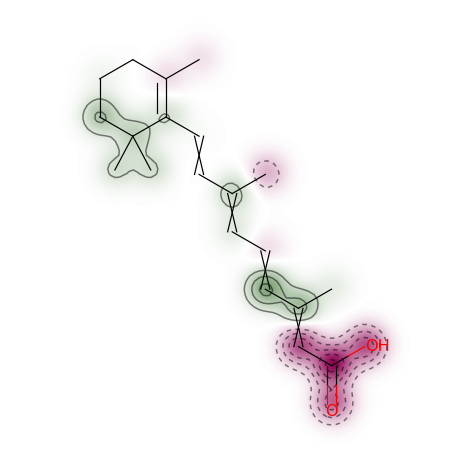

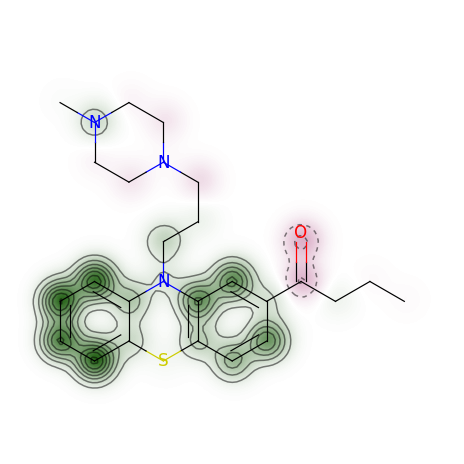

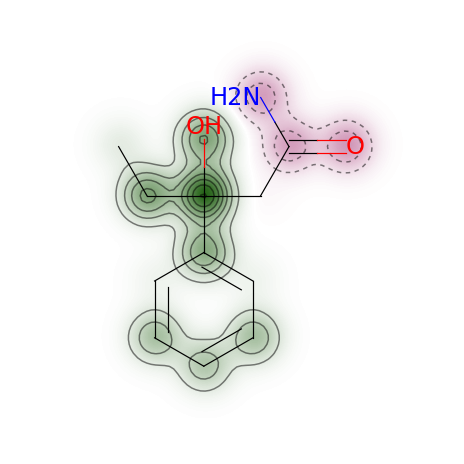

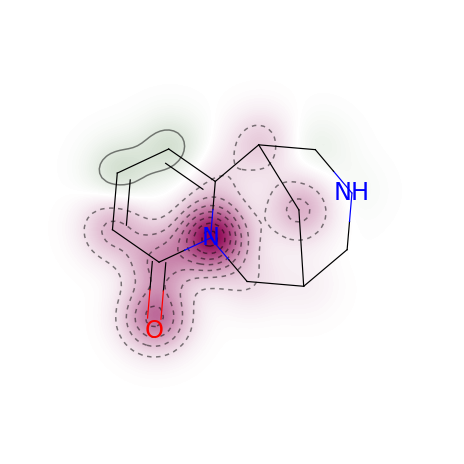

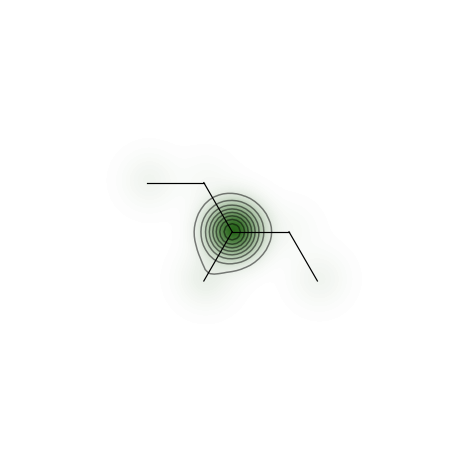

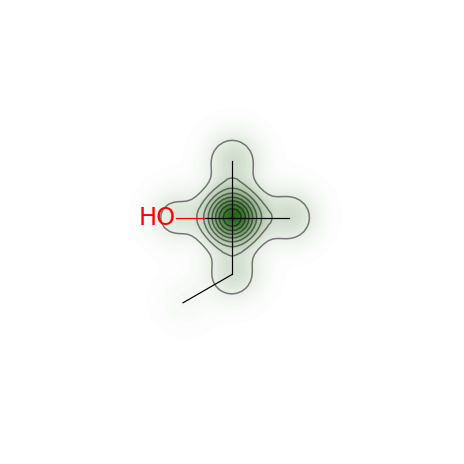

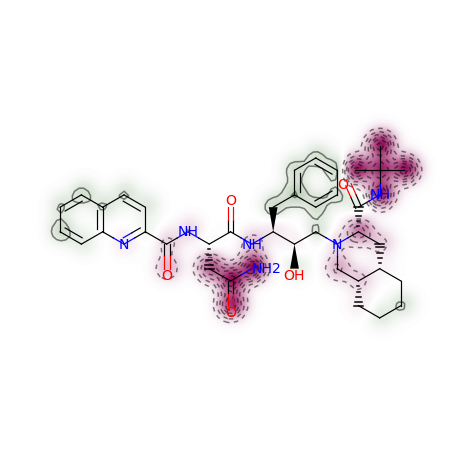

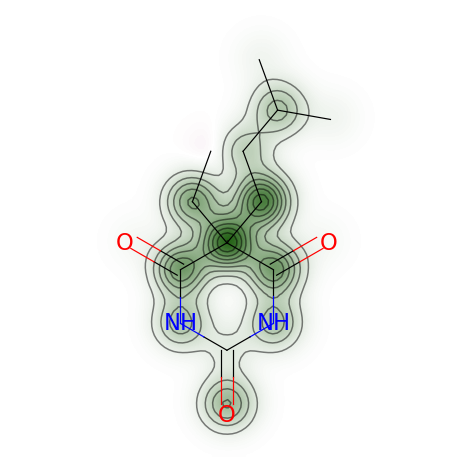

In [ ]:
np.random.seed(2000)
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

In [ ]:
import warnings; warnings.filterwarnings('ignore')
import scipy,h5py,pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from scipy import misc
from skimage.transform import resize
from skimage import color,measure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
fpath='../drive/input/molecule/'
n=np.random.choice(484,size=6,replace=False)

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU

from keras.applications.resnet50 import ResNet50,preprocess_input as rn50pi
from keras.applications.inception_v3 import InceptionV3,preprocess_input as iv3pi
from keras.applications.xception import Xception,preprocess_input as xpi
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as iv2pi
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)

In [ ]:
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

<h1 class="font-effect-3d-float" style="color:firebrick; font-family:'Monoton'; ">Molecular structure from smell</h1>

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, PandasTools

PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles')
X_train=Draw.MolsToGridImage(list(df.ROMol), useSVG=True)


m = Chem.MolFromSmiles('C1CCC1OC')
m2 = Chem.AddHs(m)
AllChem.EmbedMolecule(m2)
AllChem.UFFOptimizeMolecule(m2)

class reduce_mem_usage:
  def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    
  return df


In [ ]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])


<h1 class="font-effect-3d-float" style="color:firebrick; font-family:'Monoton'; ">Classification Models</h1>
##ResNet50

In [ ]:

x_train3 = reduce_mem_usage(train)
x_test3 = reduce_mem_usage(test)
resize_x_train3=np.array([scipy.misc.imresize(x_train3[i],(224,224,3)) 
                          for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid3=np.array([scipy.misc.imresize(x_valid3[i],(224,224,3)) 
                          for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test3=np.array([scipy.misc.imresize(x_test3[i],(224,224,3)) 
                          for i in range(0,len(x_test3))]).astype('float32')
x_train_bn3=rn50pi(resize_x_train3)
x_valid_bn3=rn50pi(resize_x_valid3)
x_test_bn3=rn50pi(resize_x_test3)
fn = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50base_model=ResNet50(weights=fn,include_top=False)
x_train_bn3=resnet50base_model.predict(x_train_bn3)
x_valid_bn3=resnet50base_model.predict(x_valid_bn3)
x_test_bn3=resnet50base_model.predict(x_test_bn3)

In [ ]:
def resnet50_model():
    model=Sequential()
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7, activation='softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
resnet50_model=resnet50_model()

In [ ]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=resnet50_model.fit(x_train_bn3,y_train3,
                   validation_data=(x_valid_bn3,y_valid3),
                   epochs=100,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 2s - loss: 2.3362 - acc: 0.2835 - val_loss: 1.0843 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 1.08428, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 1.0189 - acc: 0.6340 - val_loss: 0.6983 - val_acc: 0.8333

Epoch 00002: val_loss improved from 1.08428 to 0.69834, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 0.7675 - acc: 0.7294 - val_loss: 0.6776 - val_acc: 0.7083

Epoch 00003: val_loss improved from 0.69834 to 0.67759, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 0.8355 - acc: 0.7191 - val_loss: 0.4970 - val_acc: 0.7292

Epoch 00004: val_loss improved from 0.67759 to 0.49699, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 0.6948 - acc: 0.7835 - val_loss: 0.6276 - val_acc: 0.8333

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 0s - loss: 0.5738 - acc: 0.8196 - val_loss: 0.4780 - val_acc: 0.8125

Epoch 00006: val_loss improved from 0.49699 to 

In [ ]:
history_plot(history)
resnet50_model.load_weights(fw)
resnet50_scores=resnet50_model.evaluate(x_test_bn3,y_test3)
print("Accuracy: %.2f%%"%(resnet50_scores[1]*100))
resnet50_scores

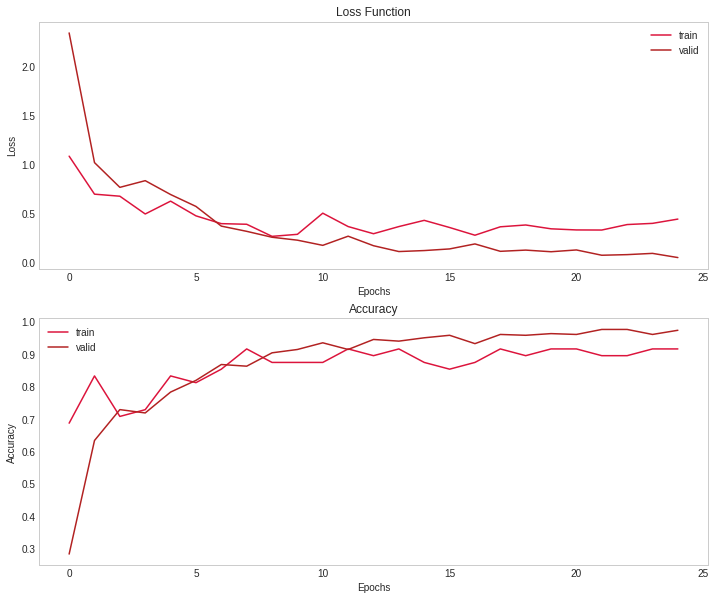

In [ ]:
# Predicting the results
resnet50_model = ir.predict(X_test)
score = metrics.accuracy_score(Y_test, resnet50_model)
display_cm(Y_test,resnet50_model, score=score)

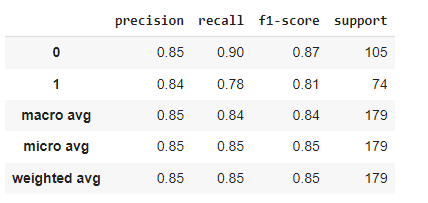

## Inception V3

In [ ]:
resize_x_train1=np.array([scipy.misc.imresize(x_train1[i],(224,224,3)) 
                          for i in range(0,len(x_train1))]).astype('float32')
resize_x_valid1=np.array([scipy.misc.imresize(x_valid1[i],(224,224,3)) 
                          for i in range(0,len(x_valid1))]).astype('float32')
resize_x_test1=np.array([scipy.misc.imresize(x_test1[i],(224,224,3)) 
                         for i in range(0,len(x_test1))]).astype('float32')
x_train_bn1=iv3pi(resize_x_train1)
x_valid_bn1=iv3pi(resize_x_valid1)
x_test_bn1=iv3pi(resize_x_test1)
fn='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionv3base_model=InceptionV3(weights=fn,include_top=False)
x_train_bn1=inceptionv3base_model.predict(x_train_bn1)
x_valid_bn1=inceptionv3base_model.predict(x_valid_bn1)
x_test_bn1=inceptionv3base_model.predict(x_test_bn1)

In [ ]:

def inception_v3_model():
    model=Sequential()    
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))       
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))
    model.add(Dense(4,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
inception_v3_model=inception_v3_model()

In [ ]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=inception_v3_model.fit(x_train_bn1,y_train1,
                               validation_data=(x_valid_bn1,y_valid1),
                               epochs=100,batch_size=128,verbose=2,
                               callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 2s - loss: 3.1472 - acc: 0.3814 - val_loss: 1.8273 - val_acc: 0.5417

Epoch 00001: val_loss improved from inf to 1.82730, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 1.8676 - acc: 0.5722 - val_loss: 1.0286 - val_acc: 0.6458

Epoch 00002: val_loss improved from 1.82730 to 1.02861, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 1.1573 - acc: 0.6572 - val_loss: 0.9149 - val_acc: 0.6875

Epoch 00003: val_loss improved from 1.02861 to 0.91491, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 0.9152 - acc: 0.5851 - val_loss: 0.8340 - val_acc: 0.6458

Epoch 00004: val_loss improved from 0.91491 to 0.83396, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 0.7182 - acc: 0.7139 - val_loss: 0.6040 - val_acc: 0.7917

Epoch 00005: val_loss improved from 0.83396 to 0.60396, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 0.6155 - acc: 0.7474 - val_loss: 0.5518 - val_acc: 0.

In [ ]:
history_plot(history)
inception_v3_model.load_weights(fw)
inception_v3_scores=inception_v3_model.evaluate(x_test_bn1,y_test1)
print("Accuracy: %.2f%%" % (inception_v3_scores[1]*100))
inception_v3_scores

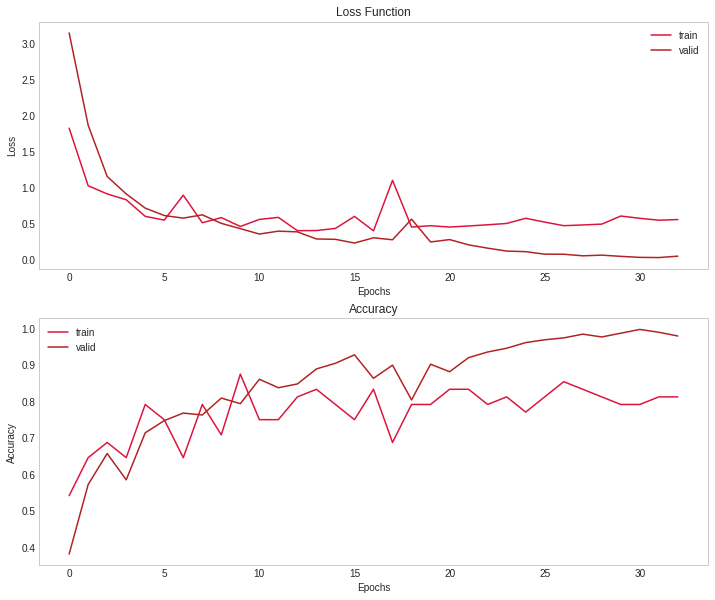

In [ ]:
# Predicting the results
inception_v3_model = ir.predict(X_test)
score = metrics.accuracy_score(Y_test, inception_v3_model)
display_cm(Y_test,inception_v3_model, score=score)

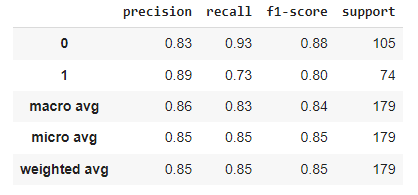

## Xception

In [ ]:
resize_x_train3=np.array([scipy.misc.imresize(x_train3[i],(71,71,3)) 
                         for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid3=np.array([scipy.misc.imresize(x_valid3[i],(71,71,3)) 
                           for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test3=np.array([scipy.misc.imresize(x_test3[i],(71,71,3)) 
                         for i in range(0,len(x_test3))]).astype('float32')
x_train_bn3=xpi(resize_x_train3)
x_valid_bn3=xpi(resize_x_valid3)
x_test_bn3=xpi(resize_x_test3)
fn='../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
xceptionbase_model=Xception(weights=fn,include_top=False)
x_train_bn3=xceptionbase_model.predict(x_train_bn3)
x_valid_bn3=xceptionbase_model.predict(x_valid_bn3)
x_test_bn3=xceptionbase_model.predict(x_test_bn3)

In [ ]:
sh=x_train_bn3.shape[1:]
def xception_model():
    model=Sequential()    
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
xception_model=xception_model()

In [ ]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=xception_model.fit(x_train_bn3,y_train3,
                           validation_data=(x_valid_bn3,y_valid3),
                           epochs=100,batch_size=128,verbose=2,
                           callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 2s - loss: 2.2985 - acc: 0.2113 - val_loss: 1.2554 - val_acc: 0.5833

Epoch 00001: val_loss improved from inf to 1.25541, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 1.1934 - acc: 0.5722 - val_loss: 1.1793 - val_acc: 0.4792

Epoch 00002: val_loss improved from 1.25541 to 1.17933, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 0.9268 - acc: 0.6778 - val_loss: 0.9970 - val_acc: 0.5417

Epoch 00003: val_loss improved from 1.17933 to 0.99702, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 0.8387 - acc: 0.7113 - val_loss: 1.2097 - val_acc: 0.5417

Epoch 00004: val_loss did not improve
Epoch 5/100
 - 0s - loss: 0.8147 - acc: 0.7216 - val_loss: 0.8441 - val_acc: 0.6458

Epoch 00005: val_loss improved from 0.99702 to 0.84411, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 0.6305 - acc: 0.7732 - val_loss: 0.8522 - val_acc: 0.7917

Epoch 00006: val_loss did not improve
Epoch 7/1

In [ ]:
history_plot(history)
xception_model.load_weights(fw)
xception_scores=xception_model.evaluate(x_test_bn3,y_test3)
print("Accuracy: %.2f%%"%(xception_scores[1]*100))
xception_scores

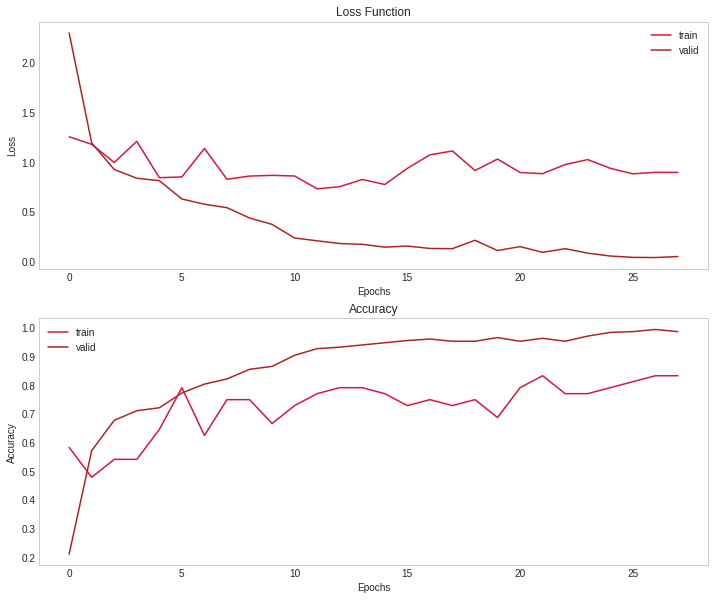

In [ ]:
# Predicting the results
xception_model = ir.predict(X_test)
score = metrics.accuracy_score(Y_test, xception_model)
display_cm(Y_test,xception_model, score=score)

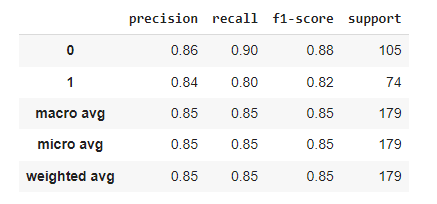

## InceptionResNetV2

In [ ]:
resize_x_train1=np.array([scipy.misc.imresize(x_train1[i],(139,139,3)) 
                          for i in range(0,len(x_train1))]).astype('float32')
resize_x_valid1=np.array([scipy.misc.imresize(x_valid1[i],(139,139,3)) 
                           for i in range(0,len(x_valid1))]).astype('float32')
resize_x_test1=np.array([scipy.misc.imresize(x_test1[i],(139,139,3)) 
                         for i in range(0,len(x_test1))]).astype('float32')
x_train_bn1=iv2pi(resize_x_train1)
x_valid_bn1=iv2pi(resize_x_valid1)
x_test_bn1=iv2pi(resize_x_test1)
fn='../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionresnetv2base_model=InceptionResNetV2(weights=fn,include_top=False)
x_train_bn1=inceptionresnetv2base_model.predict(x_train_bn1)
x_valid_bn1=inceptionresnetv2base_model.predict(x_valid_bn1)
x_test_bn1=inceptionresnetv2base_model.predict(x_test_bn1)

In [ ]:
sh=x_train_bn1.shape[1:]
def inceptionresnetv2_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(4,activation='softmax'))     
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
inceptionresnetv2_model=inceptionresnetv2_model()

In [ ]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=inceptionresnetv2_model\
.fit(x_train_bn1,y_train1,validation_data=(x_valid_bn1,y_valid1),
     epochs=100,batch_size=128,verbose=2,
     callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 6s - loss: 4.8102 - acc: 0.4562 - val_loss: 4.6486 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 4.64859, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 4.2684 - acc: 0.5593 - val_loss: 4.3698 - val_acc: 0.5417

Epoch 00002: val_loss improved from 4.64859 to 4.36976, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 3.3653 - acc: 0.5670 - val_loss: 3.5775 - val_acc: 0.5000

Epoch 00003: val_loss improved from 4.36976 to 3.57748, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 2.8541 - acc: 0.6263 - val_loss: 3.1555 - val_acc: 0.5833

Epoch 00004: val_loss improved from 3.57748 to 3.15549, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 2.0615 - acc: 0.6675 - val_loss: 1.1229 - val_acc: 0.5833

Epoch 00005: val_loss improved from 3.15549 to 1.12288, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 1.6842 - acc: 0.5722 - val_loss: 0.7951 - val_acc: 0.

In [ ]:
history_plot(history)
inceptionresnetv2_model.load_weights(fw)
inceptionresnetv2_scores=inceptionresnetv2_model.evaluate(x_test_bn1,y_test1) 
print("Accuracy: %.2f%%"%(inceptionresnetv2_scores[1]*100))
inceptionresnetv2_scores

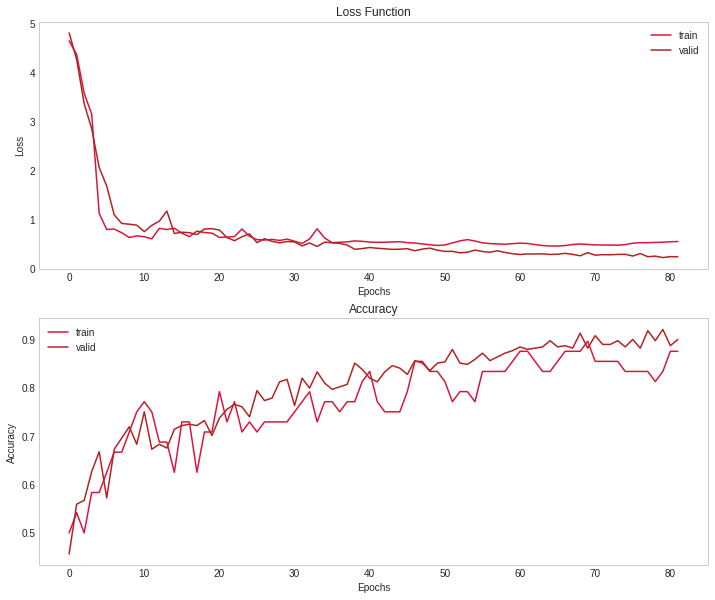

In [ ]:
# Predicting the results
inceptionresnetv2_model = ir.predict(X_test)
score = metrics.accuracy_score(Y_test, inceptionresnetv2_model)
display_cm(Y_test, inceptionresnetv2_model, score=score)

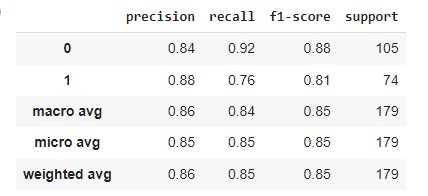

#Prediction based on dataset

In [ ]:
labels = []
for x in train_df.SENTENCE.tolist():
  labels.append(get_ohe_label(x))
data_df = pd.DataFrame(train_df["SMILES"].tolist(),columns=["text"])#pd.DataFrame(labels,columns = vocab)
data_df["labels"]= labels
data_df.head()

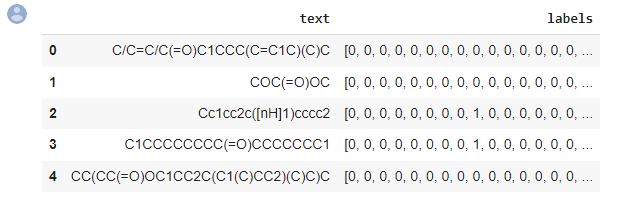

In [ ]:
#wrong predictions
import sklearn
result, model_outputs, wrong_predictions = model.eval_model(test_dataset)
print(result)
print(model_outputs)

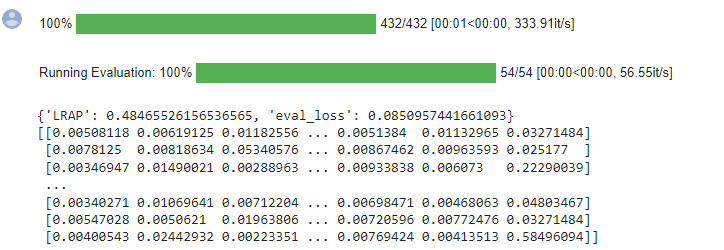

Generate the test predictions

In [ ]:
test_df = pd.read_csv("/drive/data/test.csv")
test_df.head()

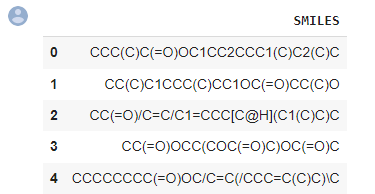

In [ ]:
predictions, raw_outputs = model.predict(test_df["SMILES"].tolist())

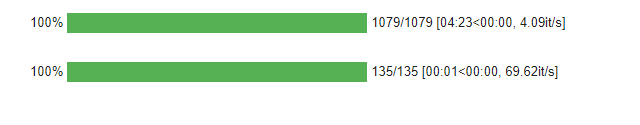

In [ ]:
from tqdm.notebook import tqdm  #used for creating Progress Meters
final_preds=[]
for i,row in tqdm(test_df.iterrows(),total=len(test_df)):
    #predictions, raw_outputs = model.predict([row["SMILES"]])
    order = np.argsort(raw_outputs[i])[::-1][:15]
    labelled_preds = [vocab[i] for i in order]
    for x in labelled_preds:
      assert x in vocab
    sents = []
    for sent in range(0,15,3):
      sents.append(",".join([x for x in labelled_preds[sent:sent+3]]))
    pred = ";".join([x for x in sents])
    final_preds.append(pred)
print(len(final_preds),len(test_df))

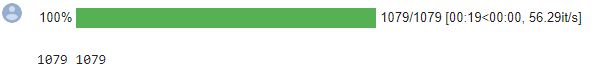

In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":final_preds})
final.head()

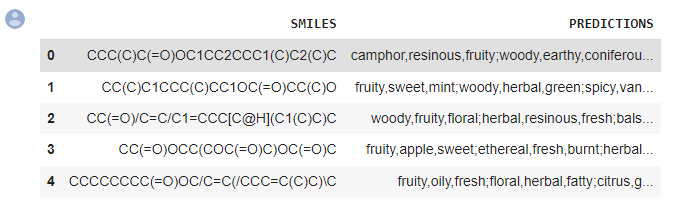

In [ ]:
final.tail()

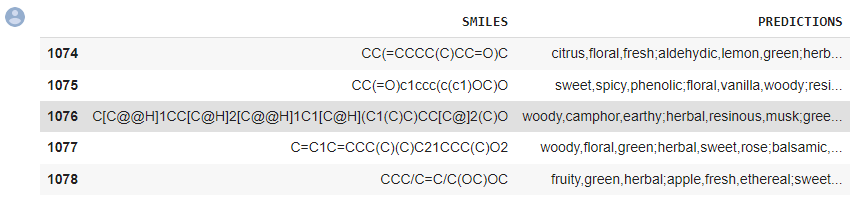

In [ ]:
#COMMONLY OCCURRNG SMELL CLASES
from sklearn.preprocessing import MultiLabelBinarizer #encodes multi-label per instance 
def make_sentence_list(sent):
  return sent.split(",")
train_df = pd.read_csv("/content/data/train.csv")
train_df["SENTENCE_LIST"] = train_df.SENTENCE.apply(make_sentence_list)
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_df.SENTENCE_LIST)
Y = multilabel_binarizer.transform(train_df.SENTENCE_LIST)
d = {}
for x,y in zip(multilabel_binarizer.classes_,Y.sum(axis=0)):
  d[x]=y

d = sorted(d.items(), key=lambda x: x[1], reverse=True)
top_15 = [x[0] for x in d[:20]]
top_15

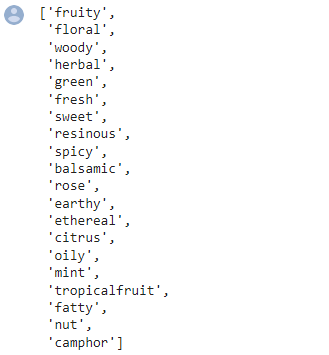

In [ ]:
import deepchem as dc
mols = [Chem.MolFromSmiles(smile) for smile in data_df["text"].tolist()]
feat = dc.feat.ConvMolFeaturizer()
arr = feat.featurize(mols)
print(arr.shape)



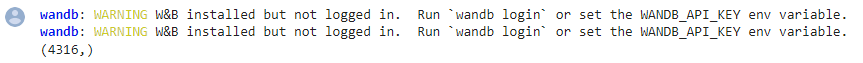

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

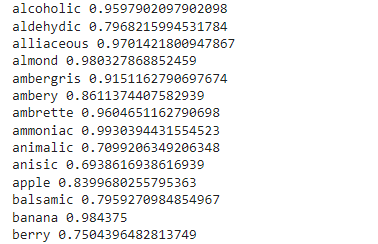

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

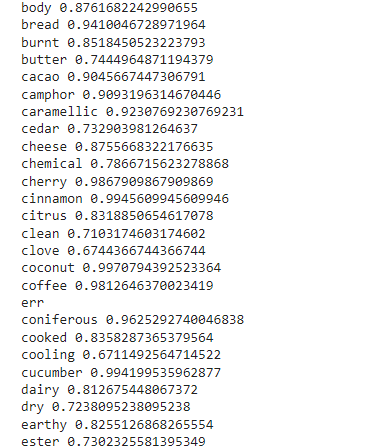

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

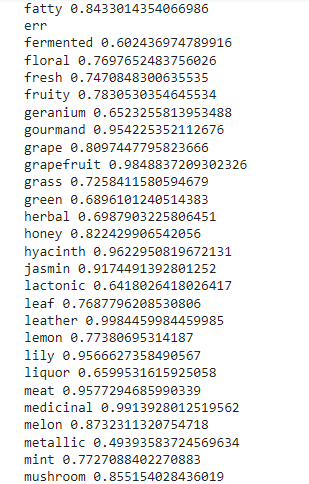

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

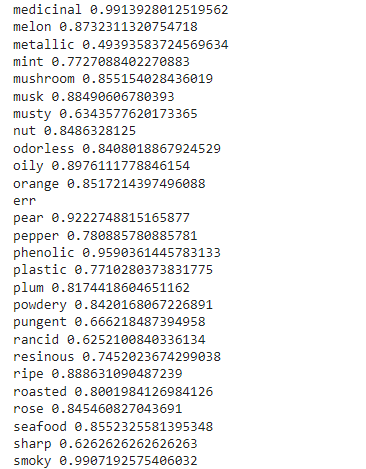

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

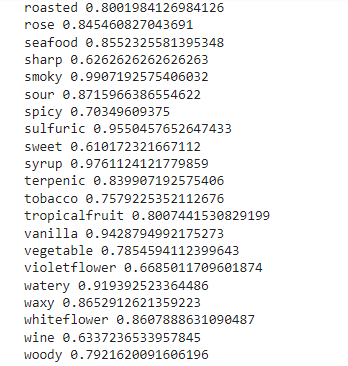

In [ ]:
#frequenty occuring multi-label smell for different molecules
y_true = val_dataset.y
y_pred = model.predict(val_dataset)

for i in range(y_true.shape[0]):
  final_pred = []
  prob_val = []
  for y in range(109):
      prediction = y_pred[i,y]
      if prediction[1] > 0.37:
        final_pred.append(1)
        prob_val.append(prediction[1])
      else:
        final_pred.append(0)
  smell_ids = np.where(np.array(final_pred)==1)
  smells = [vocab[k] for k in smell_ids[0]]
  smells = [smells[k] for k in np.argsort(np.array(prob_val))] #to further order based on probability
  gt_smell_ids = np.where(np.array(y_true[i])==1)
  gt_smells = [vocab[k] for k in gt_smell_ids[0]]
  print(smells,gt_smells)


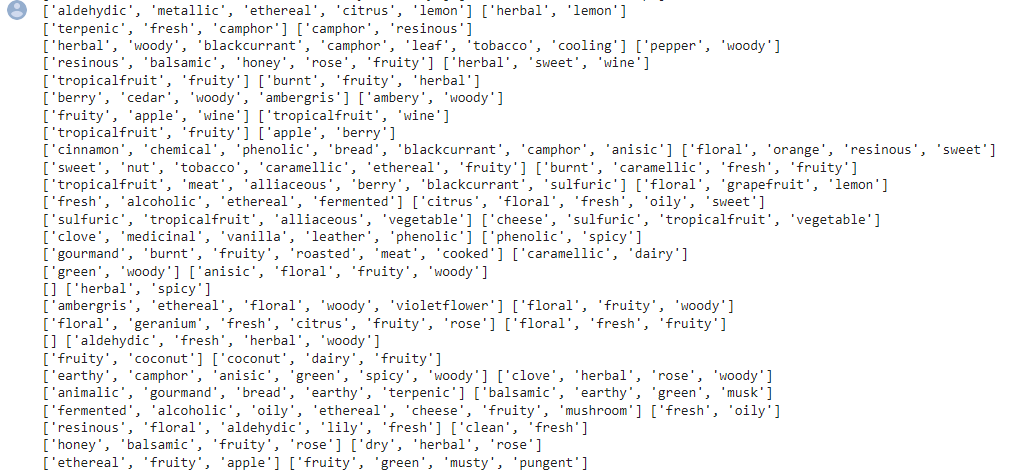

In [ ]:
from rdkit import Chem 
train["mol"] = train["SMILES"].apply(Chem.MolFromSmiles)
mol = train["mol"][1]
dims = int(embed*2/res)
cmol = Chem.Mol(mol.ToBinary())
cmol.ComputeGasteigerCharges()
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect
    
data = pd.read_csv("data/train.csv")
data["mol"] = data["SMILES"].apply(Chem.MolFromSmiles)

In [ ]:
mol = data["mol"][3]
v = chemcepterize_mol(mol, embed=18, res=0.5)
print(v.shape)
plt.imshow(v[:,:,:3])
plt.axis('off')
plt.title("Chemceptionized Molecule")
plt.show()

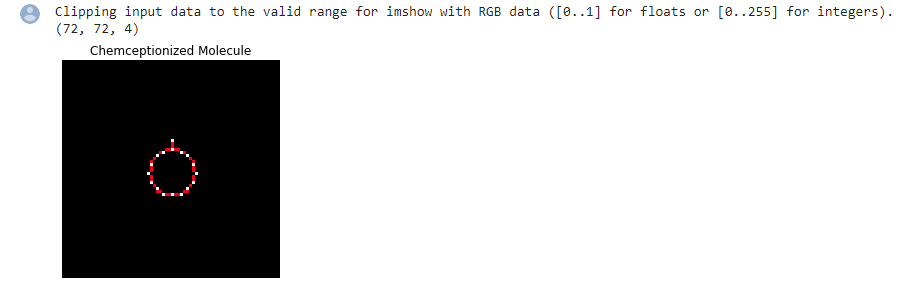

In [ ]:
import sys
import os
import gc
import warnings
import torch

import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from tqdm.notebook import tqdm

In [ ]:
np.random.seed(42) # set random seed so we always get the same validation set
src =  (ImageList.from_df(path="/content/molecule_data/train", df=new_data, cols=["FILENAME"]).split_by_rand_pct(0.2).label_from_df(label_delim=',').databunch(num_workers=0,bs=64)).normalize(imagenet_stats)    

In [ ]:
src.show_batch(rows=3, figsize=(12, 9))

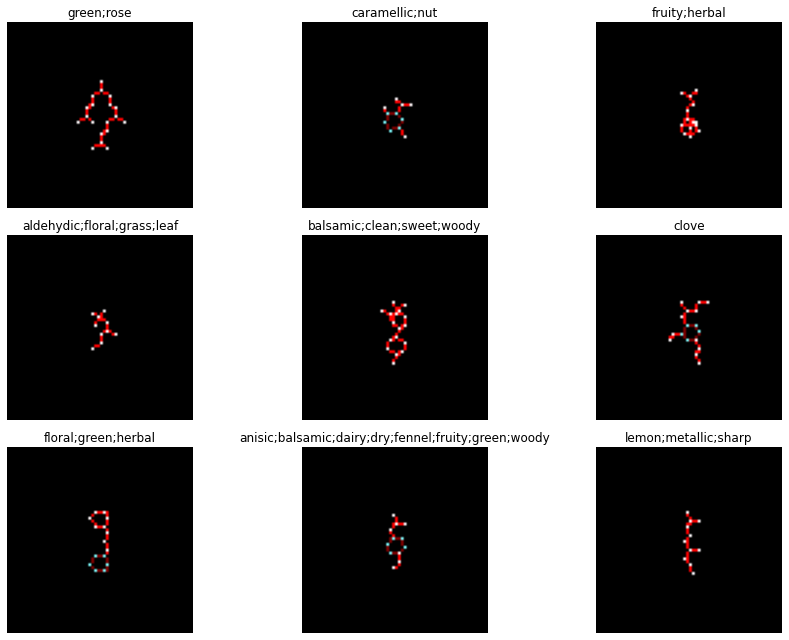

In [ ]:
# create metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
# create cnn with the vgg19 architecture
learn = cnn_learner(src, models.vgg19_bn, metrics=[acc_02, f_score])

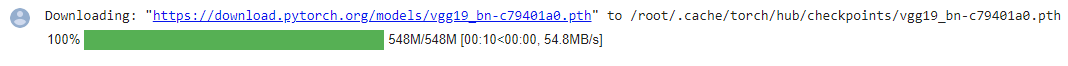

In [ ]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate

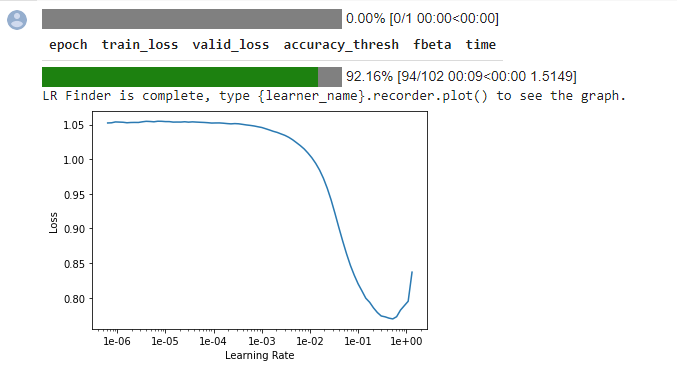

In [ ]:
learn.unfreeze() # unfreeze all layers

learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate

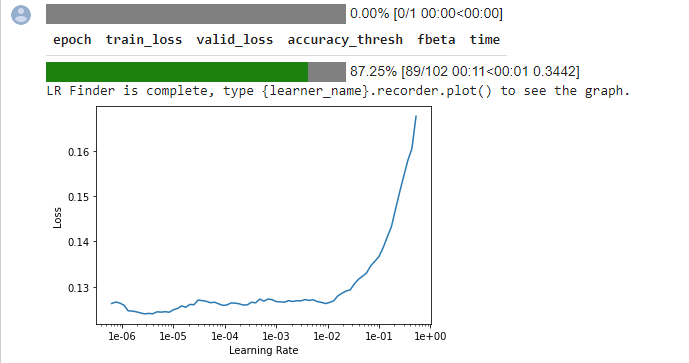

In [ ]:
learn.fit_one_cycle(15, slice(1e-5, lr/5)) # fit model with differential learning rates

learn.save('chemception-stage-2') # save model

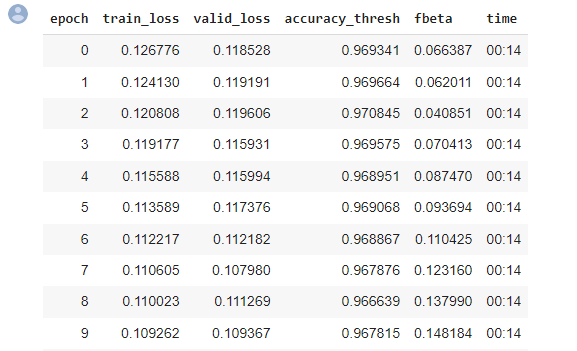

In [ ]:
val_fns = [str(x) for x in learn.data.valid_ds.items]
val_fns_y=[str(x) for x in learn.data.valid_ds.y]

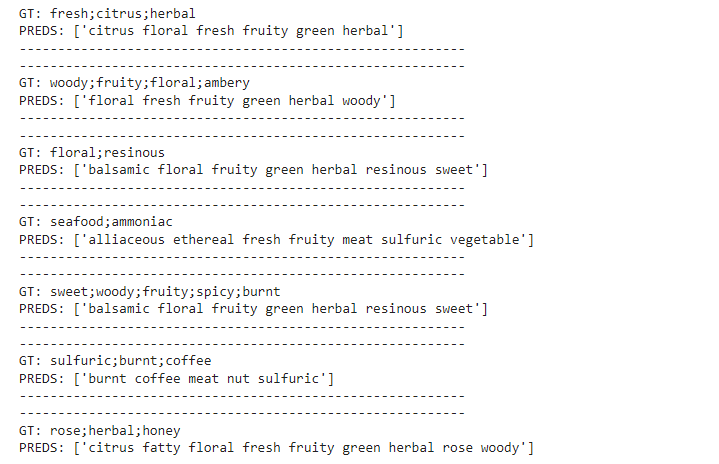

In [ ]:
for img,gt in zip(val_fns,val_fns_y):
  pred_class, pred_idx, preds=learn.predict(open_image(img))
  print("----------------------------------------------------------")
  thresh = 0.1
  labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(preds) if p > thresh])]
  print("GT:",gt)
  print("PREDS:",labelled_preds)
  print("----------------------------------------------------------")


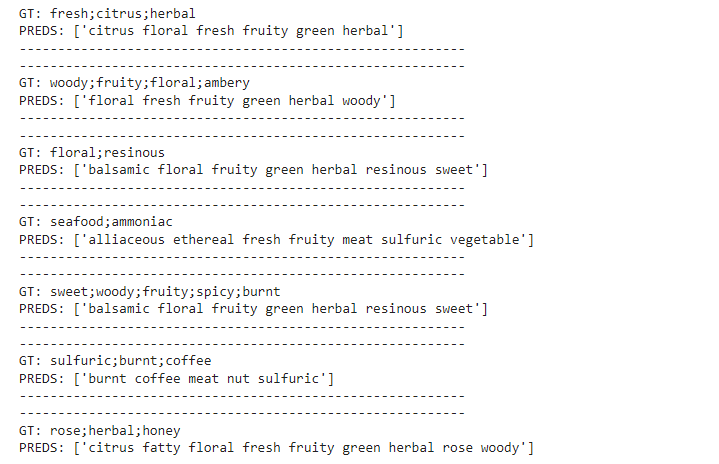

In [ ]:
#MAJOR ODOR CLASSES
order = np.argsort(preds).cpu().numpy()[::-1][:15]
labelled_preds = [learn.data.classes[i] for i in order]
sents = []
for sent in range(0,15,3):
  sents.append(",".join([x for x in labelled_preds[sent:sent+3]]))
pred = ";".join([x for x in sents])
pred

Screenshot (168).png